Example:

python roi_blob_detector.py -S'/nas/volume1/2photon/projects' -E'gratings_phaseMod' -s'20170901_CE054' -A'FOV1_zoom3x' -f'functional_sub' -r3 -m3 -M10 -H100 -t.05 -G3

In [1]:
# Adapted from the skimage blob detector example code
import tifffile as tf
from math import sqrt
from skimage import filters
from skimage import data
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray
from scipy.misc import imread
import matplotlib.pyplot as plt
from skimage.exposure import equalize_adapthist
from numpy.core.records import fromarrays

import os
import numpy as np
import scipy.io
import itertools

import optparse

def createCircularMask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = [int(w/2), int(h/2)]
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

tifffile.py:284: UserWarning: ImportError: No module named '_tifffile'. Loading of some compressed images will be very slow. Tifffile.c can be obtained at http://www.lfd.uci.edu/~gohlke/
  "ImportError: No module named '_tifffile'. "


In [2]:
%matplotlib inline

In [70]:
# ----------------------------------------------------------
# OPT PARSE VARIABLES:
# ----------------------------------------------------------

nslices = 41 #options.nslices
reference_file_idx = 2 #options.reference
signal_channel_idx = 1 #options.channel

source = '/nas/volume1/2photon/projects' #options.source
experiment = 'scenes' #options.experiment
sess = '20171003_JW016' #options.sess
acquisition = 'FOV1' #options.acquisition
functional_subdir = 'functional' #options.functional_dir

avgsource = 'Corrected' #options.avgsource

# max_sigma_val = float(options.max_sigma)
# min_sigma_val = float(options.min_sigma)
# blob_threshold = float(options.blob_threshold)
# hist_kernel = float(options.hist_kernel)
# gaussian_sigma = float(options.gaussian_sigma)


In [74]:
# Make directories:
if len(avgsource)==0:
    avgsource = '_Parsed'
else:
    avg_dir = '_%s' % avgsource
    
subdir_str = '{tiffstr}/DATA/Averaged_Slices{avgsource}'.format(avgsource=avg_dir, tiffstr=functional_subdir)

signal_channel = 'Channel%02d' % int(signal_channel_idx)
reference_file = 'File%03d' % int(reference_file_idx)

print "Specified signal channel is:", signal_channel
print "Selected reference file:", reference_file

slice_directory = os.path.join(source, experiment, sess, acquisition, subdir_str, signal_channel, reference_file)

# Define output directories:
log_roi_dir = os.path.join(source, experiment, sess, acquisition, 'ROIs', 'blobs_LoG')
if not os.path.exists(log_roi_dir):
    os.makedirs(log_roi_dir)

dog_roi_dir = os.path.join(source, experiment, sess, acquisition, 'ROIs', 'blobs_DoG')
if not os.path.exists(dog_roi_dir):
    os.makedirs(dog_roi_dir)
    
log_fig_dir = os.path.join(log_roi_dir,'figures')
if not os.path.exists(log_fig_dir):
    os.mkdir(log_fig_dir)

dog_fig_dir = os.path.join(dog_roi_dir,'figures')
if not os.path.exists(dog_fig_dir):
    os.mkdir(dog_fig_dir)

log_mask_dir = os.path.join(log_roi_dir,'masks')
if not os.path.exists(log_mask_dir):
    os.mkdir(log_mask_dir)

dog_mask_dir = os.path.join(dog_roi_dir,'masks')
if not os.path.exists(dog_mask_dir):
    os.mkdir(dog_mask_dir)


Specified signal channel is: Channel01
Selected reference file: File002


In [76]:
#get averaged slices
avg_slices = os.listdir(slice_directory)
avg_slices = [i for i in avg_slices if i.endswith('.tif')]

print "N slices: ", len(avg_slices)
if len(avg_slices)==0:
    nslices = len(avg_slices)
else:
    nslices = int(nslices)    

#initialize empty dictionaries to populate as we go on
source_paths = np.zeros((nslices,), dtype=np.object)
log_maskpaths = np.zeros((nslices,), dtype=np.object)
dog_maskpaths = np.zeros((nslices,), dtype=np.object)
log_rois = np.zeros((nslices,), dtype=np.object)
dog_rois = np.zeros((nslices,), dtype=np.object)
log_nrois = np.zeros((nslices,))
dog_nrois = np.zeros((nslices,))

N slices:  41


In [77]:
# Read the image

currslice = 20 #13 #20

currslice_name = 'slice%i' % int(currslice+1)
print currslice_name


#get tif file name
tiff_path = os.path.join(slice_directory, avg_slices[currslice])
#tiff_path = '/nas/volume1/2photon/projects/scenes/20171003_JW016/FOV1/functional/DATA/test_raw_averages/display_AVG_jwr16_tefo_planar_p18_d0_500_Slice20_Channel01_File002.tif'

#save for later
#source_paths[currslice] = tiff_path

#Read in
with tf.TiffFile(tiff_path) as tif:
    image = tif.asarray()#numpy array

print image.shape

# image = cv2.imread(os.path.join(source_dir, avg_vol_dir, avg_slices[currslice]), -1)
# print image.shape

slice21
(100, 120)


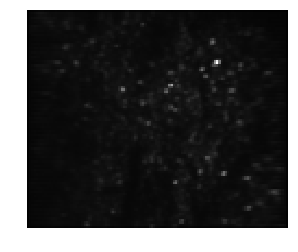

In [78]:
plt.imshow(image, cmap='gray'); plt.axis('off'); plt.show()

In [79]:
# ----------------------------------------------------------
# OPT PARSE VARIABLES:
# ----------------------------------------------------------
# gaussian_sigma = 2
# hist_kernel = 20 #10

# max_sigma_val = 10 #2
# min_sigma_val = 4 #0.2

# threshold = 0.005

# gaussian_sigma = float(options.gaussian_sigma)
# hist_kernel = float(options.hist_kernel)

# max_sigma_val = float(options.max_sigma)
# min_sigma_val = float(options.min_sigma)
# blob_threshold = float(options.blob_threshold)


In [80]:
# Gaussian blur
gaussian_sigma = 1
image_gaussian = filters.gaussian(image, sigma=gaussian_sigma)

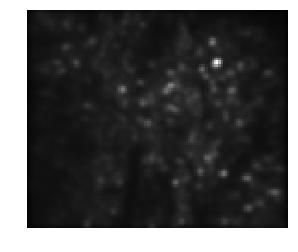

In [81]:
plt.imshow(image_gaussian, cmap='gray'); plt.axis('off'); plt.show()

In [87]:
# CLAHE
hist_kernel = 15
image_processed = equalize_adapthist(image_gaussian, kernel_size=hist_kernel)

#image_processed = image_gaussian


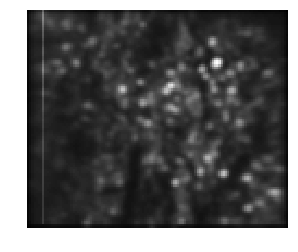

In [88]:
plt.imshow(image_processed, cmap='gray'); plt.axis('off'); plt.show()

In [89]:
# Laplacian of Gaussians
# blobs_log = blob_log(image_processed, max_sigma=6, min_sigma=3, threshold=.01)
max_sigma_val = 2
min_sigma_val = 0.5
blob_threshold = .01

blobs_log = blob_log(image_processed, max_sigma=max_sigma_val, min_sigma=min_sigma_val, threshold=blob_threshold)
blobs_log = blob_log(image_processed, max_sigma=max_sigma_val, min_sigma=min_sigma_val, threshold=blob_threshold)

blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2) # Compute radii in the 3rd column.


In [90]:
# Difference of Gaussians
blobs_dog = blob_dog(image_processed, max_sigma=max_sigma_val, min_sigma=min_sigma_val, threshold=blob_threshold)
blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)


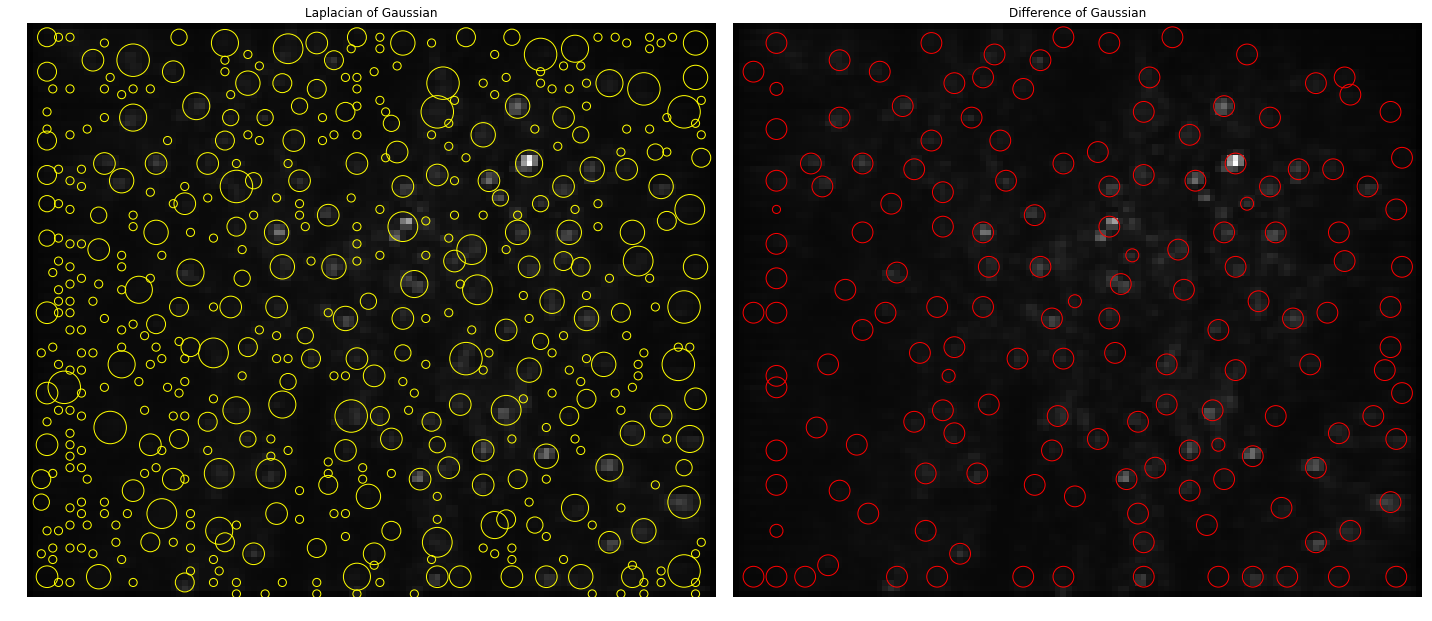

In [93]:
blobs_list = [blobs_log, blobs_dog]
colors = ['yellow', 'red']
titles = ['Laplacian of Gaussian', 'Difference of Gaussian']
sequence = zip(blobs_list, colors, titles)

fig, axes = plt.subplots(1, 2, figsize=(20, 10), sharex=True, sharey=True,
                         subplot_kw={'adjustable': 'box-forced'})
ax = axes.ravel()

for idx, (blobs, color, title) in enumerate(sequence):
    ax[idx].set_title(title)
    ax[idx].imshow(image, interpolation='nearest', cmap='gray')
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color=color, linewidth=1, fill=False)
        ax[idx].add_patch(c)
    ax[idx].set_axis_off()

plt.tight_layout()

In [ ]:
print "gaussian_sigma:", gaussian_sigma
print "hist_kernel:", hist_kernal
print "max_sigma_val:", max_sigma_val
print "min_sigma_val = float(options.min_sigma)
# blob_threshold = float(options.blob_threshold)



Slice07_ROIs_corrected_File001.png


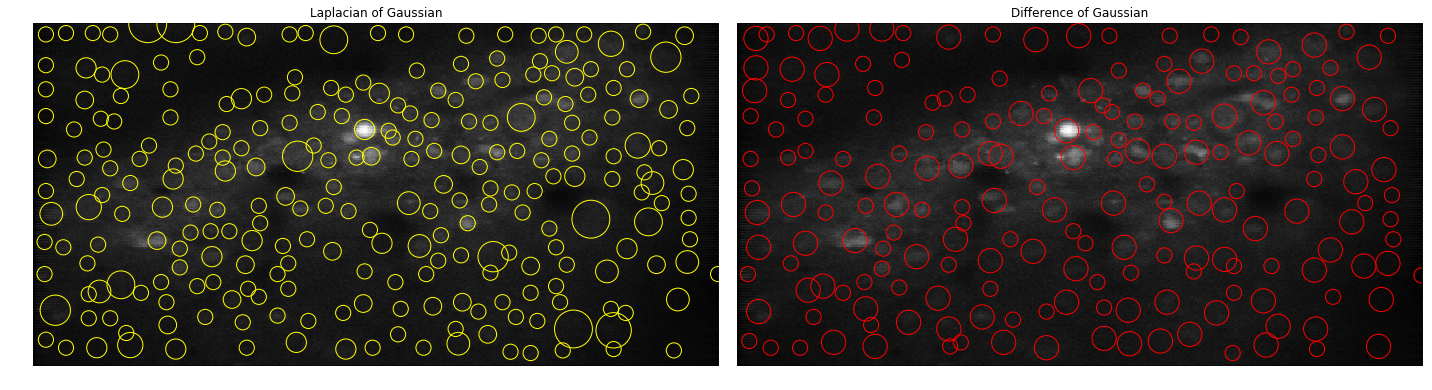

In [58]:
# Plot that shit

# blobs_list = [blobs_log, blobs_dog]
# colors = ['yellow', 'red']
# titles = ['Laplacian of Gaussian', 'Difference of Gaussian']
# sequence = zip(blobs_list, colors, titles)

# fig, axes = plt.subplots(1, 2, figsize=(20, 10), sharex=True, sharey=True,
#                          subplot_kw={'adjustable': 'box-forced'})
# ax = axes.ravel()

# for idx, (blobs, color, title) in enumerate(sequence):
#     ax[idx].set_title(title)
#     ax[idx].imshow(image, interpolation='nearest', cmap='gray')
#     for blob in blobs:
#         y, x, r = blob
#         c = plt.Circle((x, y), r, color=color, linewidth=1, fill=False)
#         ax[idx].add_patch(c)
#     ax[idx].set_axis_off()

# plt.tight_layout()

# imname = 'Slice%02d_ROIs_%s.png' % (currslice, avg_vol_dir.replace('/', '_'))
# print imname

# roi_dir = 'ROIs_%s' % avg_vol_dir.replace('/', '_')
# if not os.path.exists(os.path.join(source_dir, roi_dir)):
#     os.mkdir(os.path.join(source_dir, roi_dir))
    
# plt.savefig(os.path.join(source_dir, roi_dir, imname))

# plt.show()

## Process all slices:

slice1
(120, 120)
Slice01_ROIs_average_slices.png


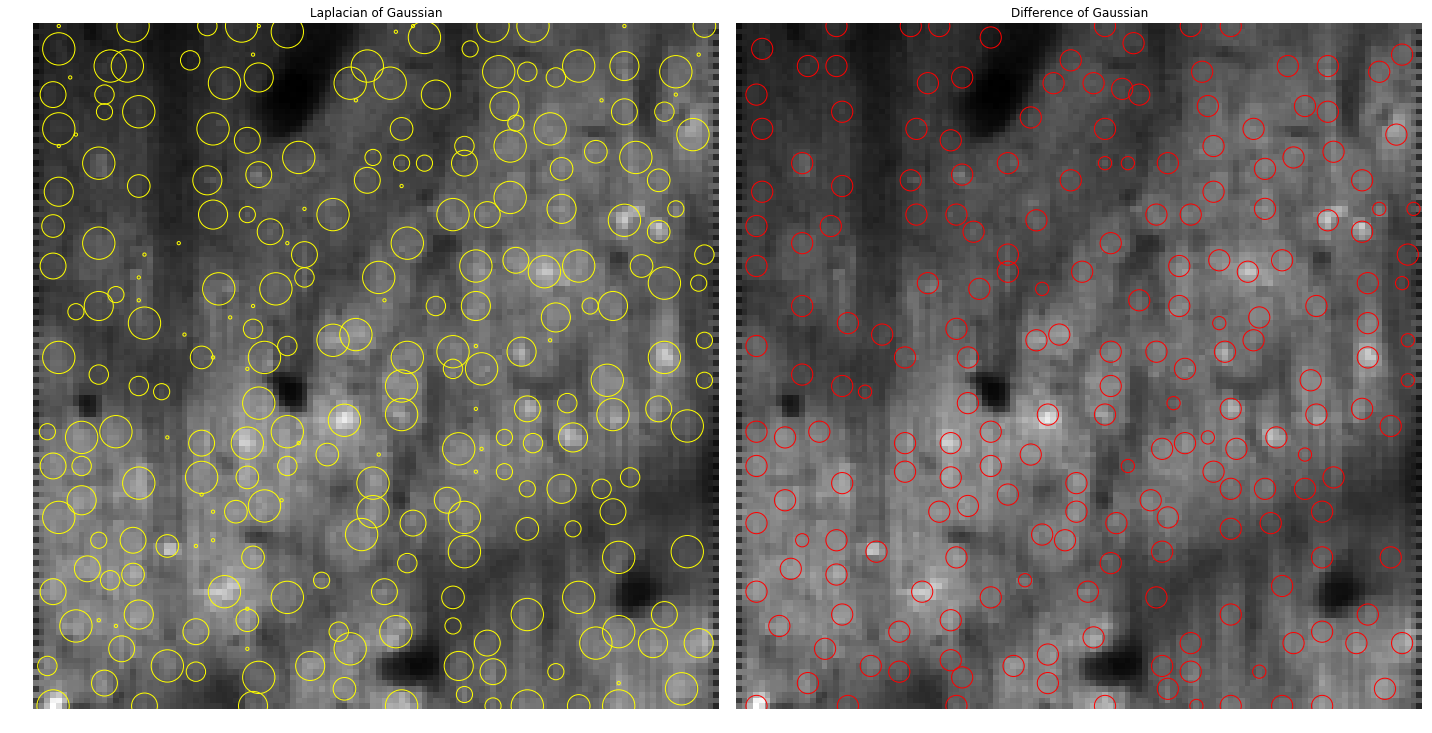

slice2
(120, 120)
Slice02_ROIs_average_slices.png


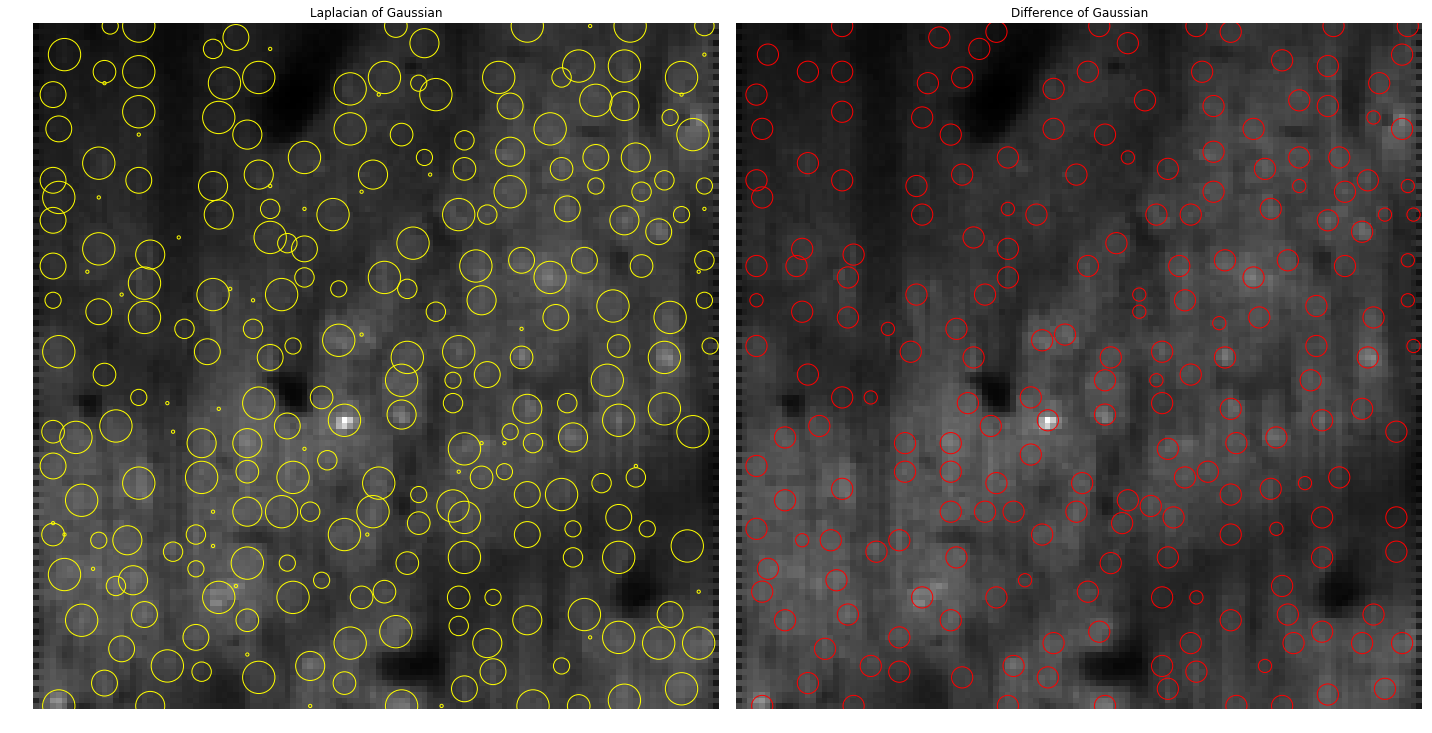

slice3
(120, 120)
Slice03_ROIs_average_slices.png


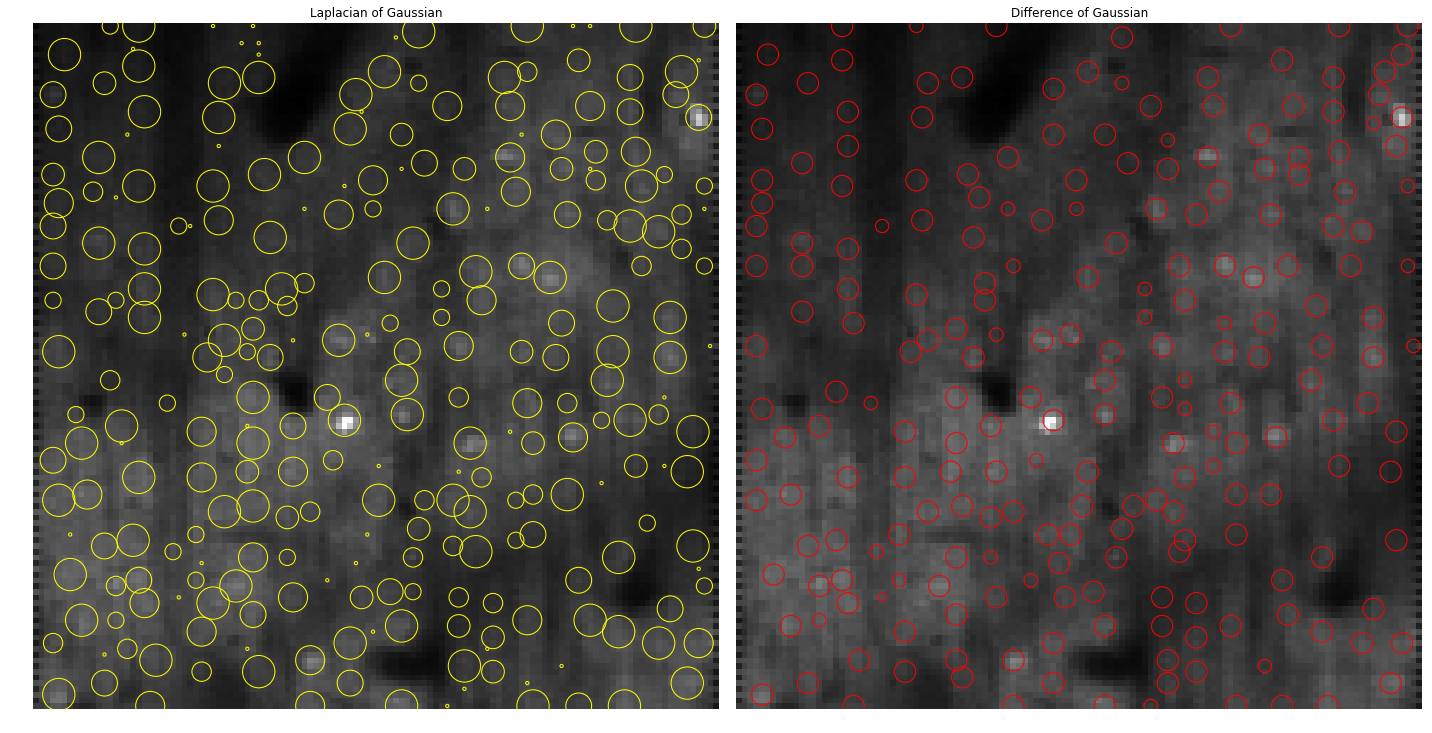

slice4
(120, 120)
Slice04_ROIs_average_slices.png


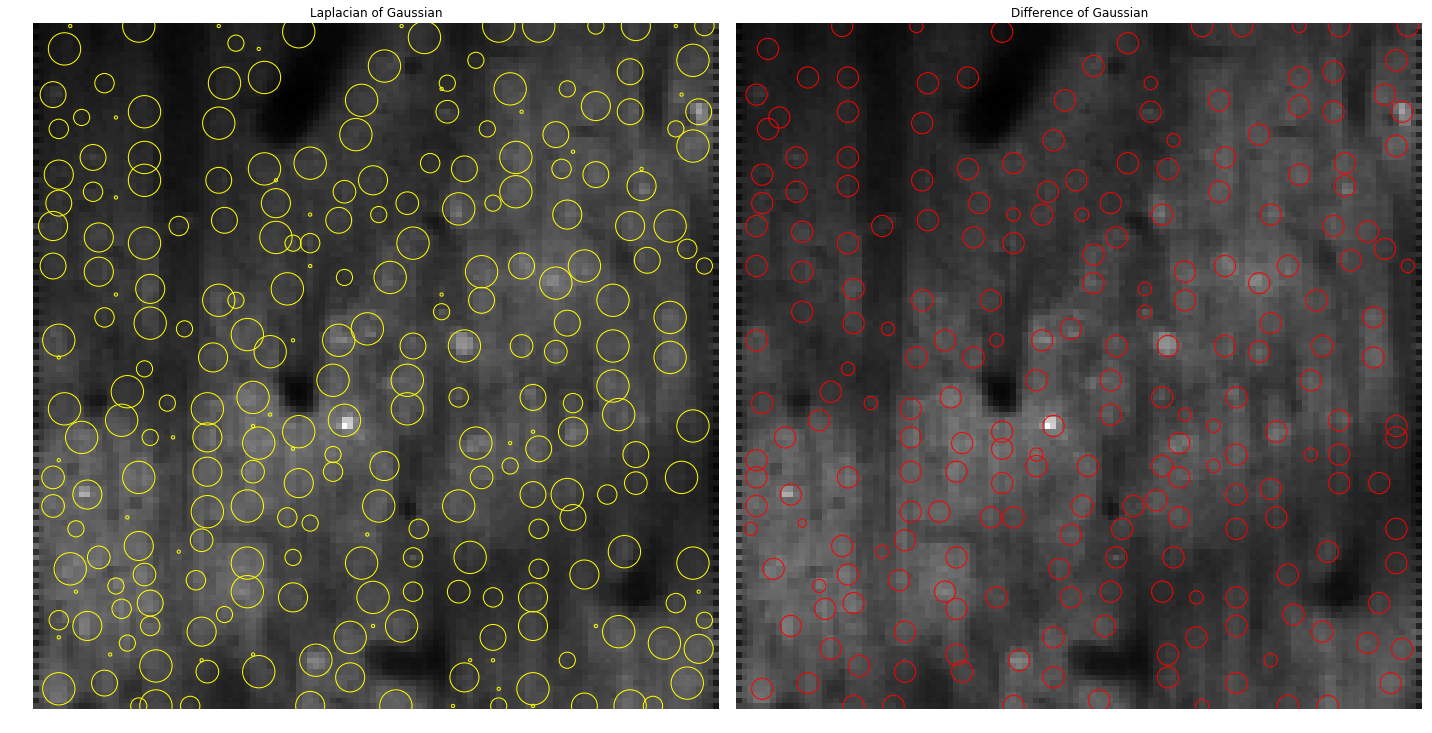

slice5
(120, 120)
Slice05_ROIs_average_slices.png


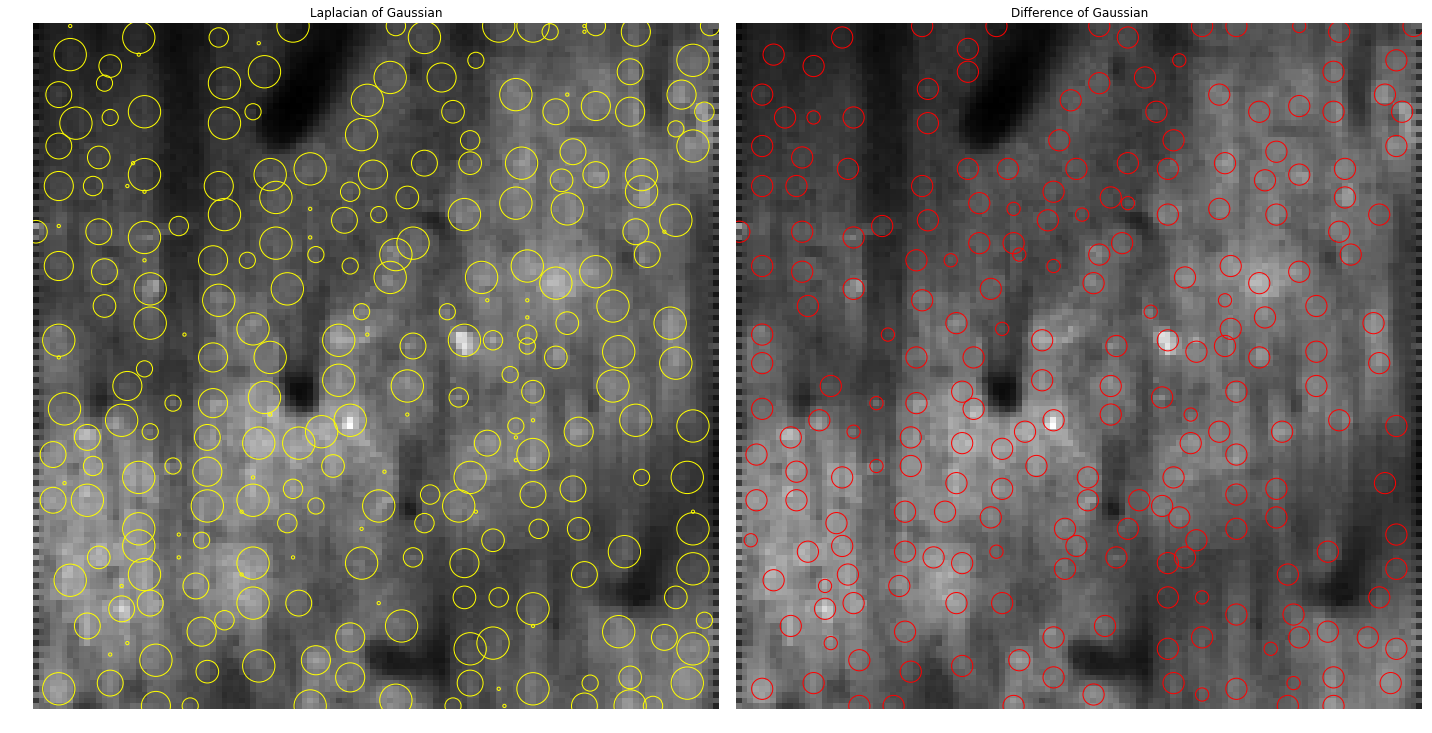

slice6
(120, 120)
Slice06_ROIs_average_slices.png


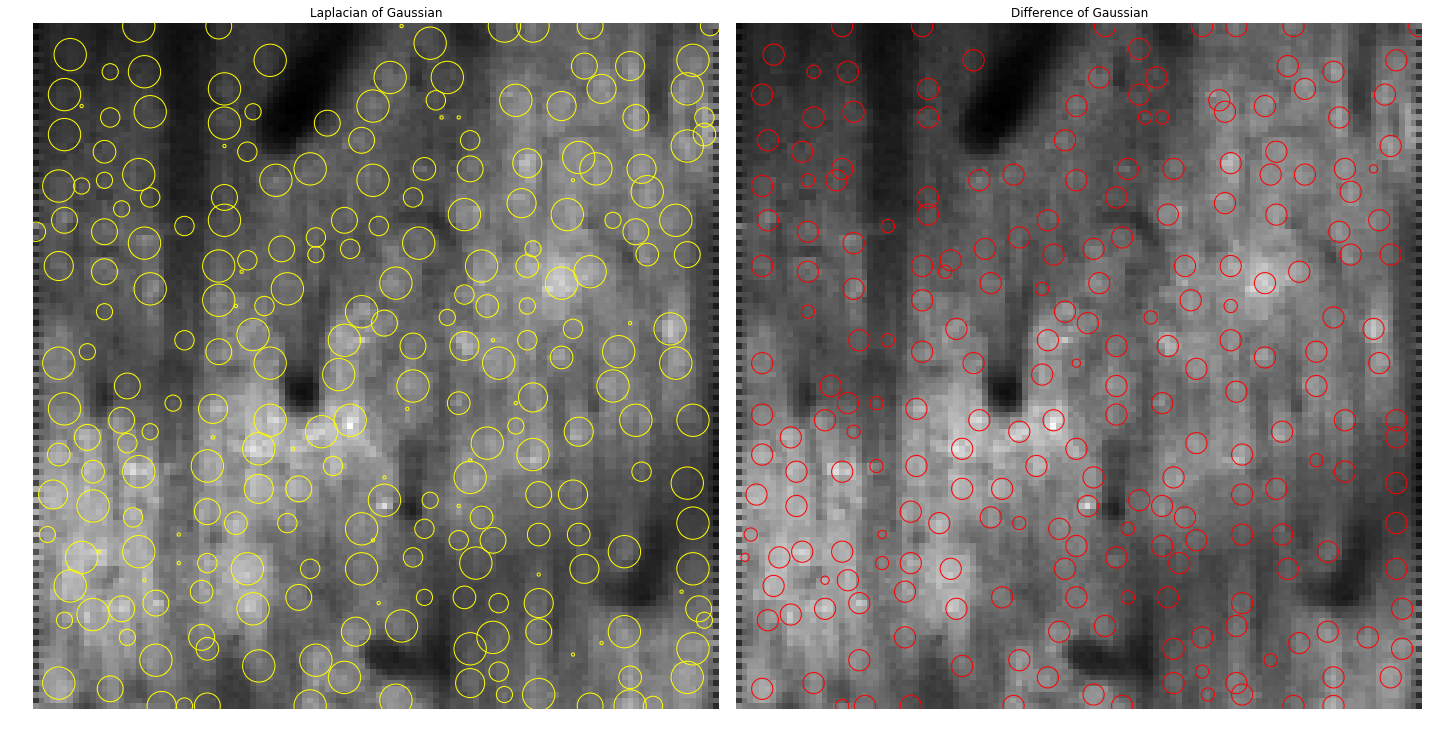

slice7
(120, 120)
Slice07_ROIs_average_slices.png


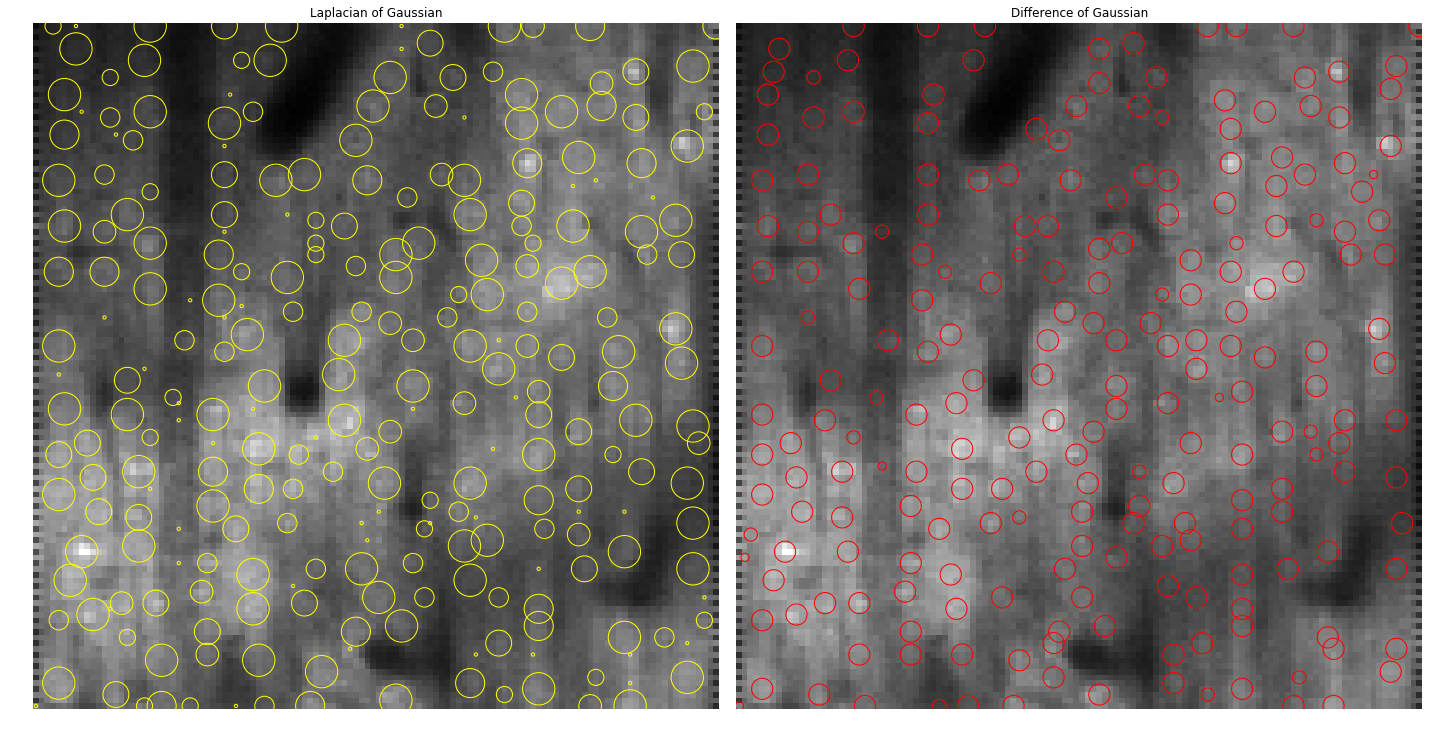

slice8
(120, 120)
Slice08_ROIs_average_slices.png


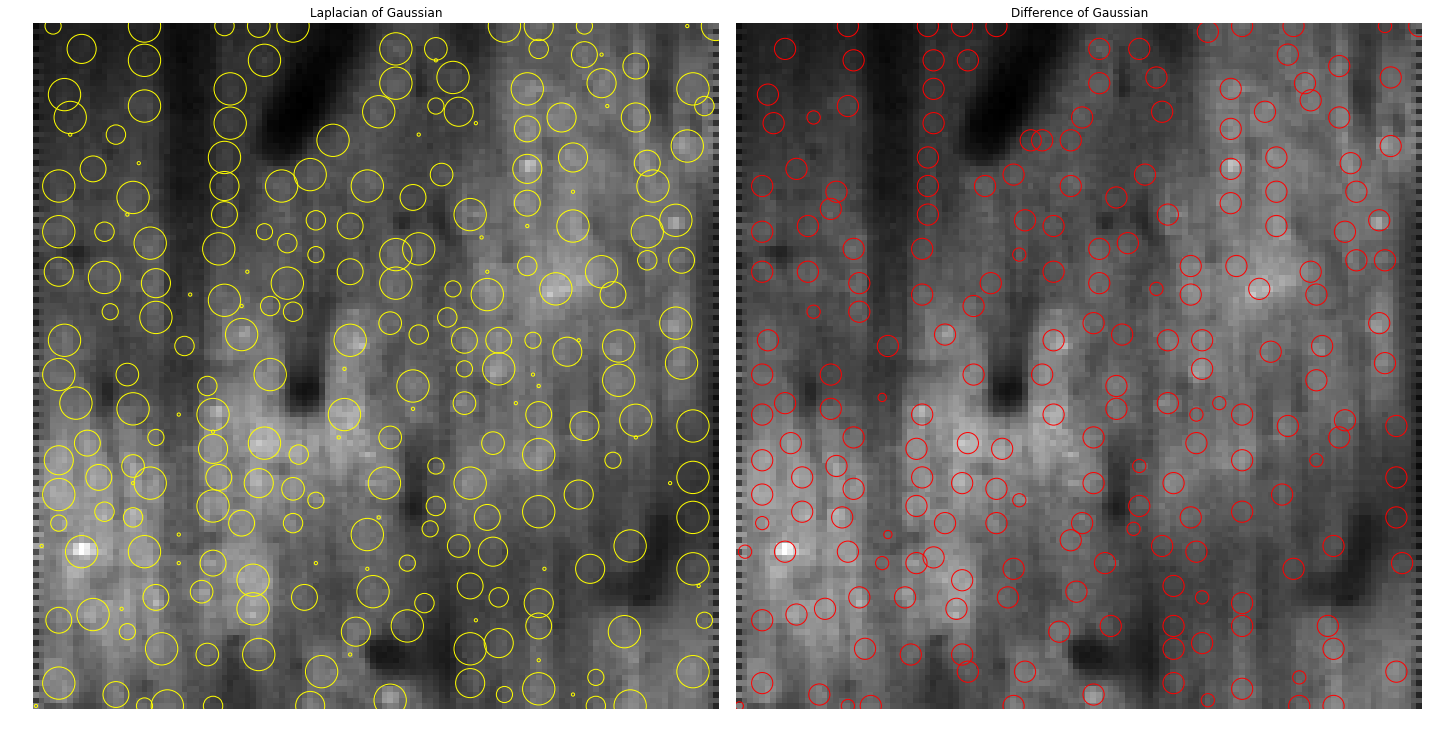

slice9
(120, 120)
Slice09_ROIs_average_slices.png


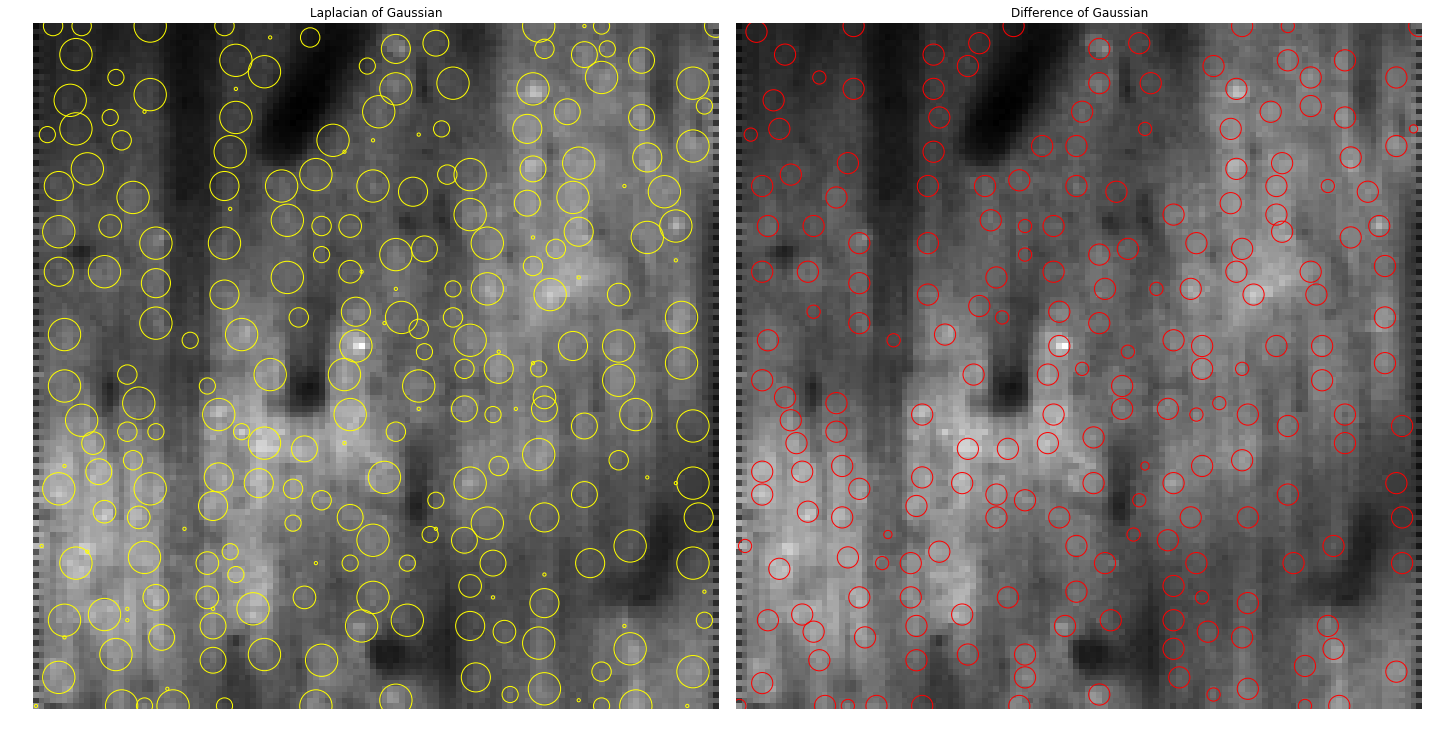

slice10
(120, 120)
Slice10_ROIs_average_slices.png


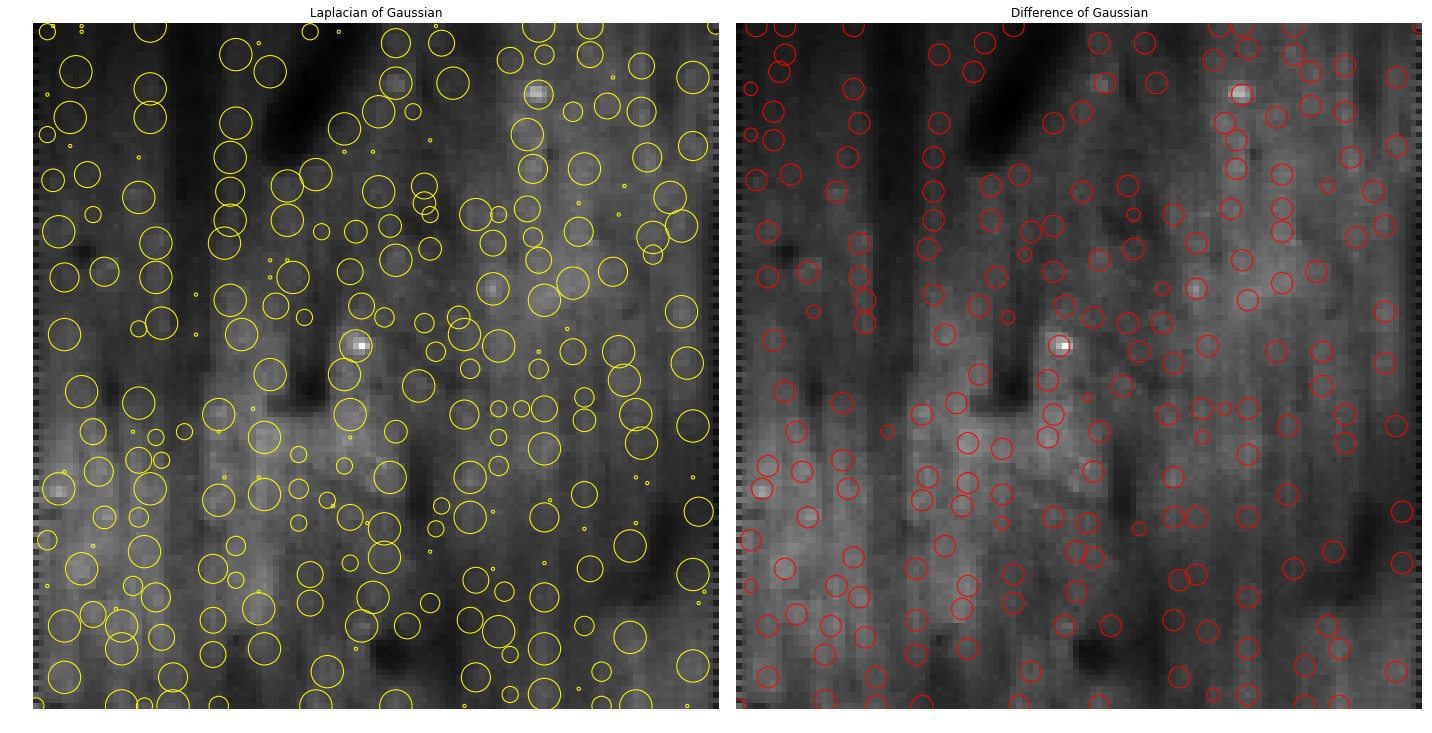

slice11
(120, 120)
Slice11_ROIs_average_slices.png


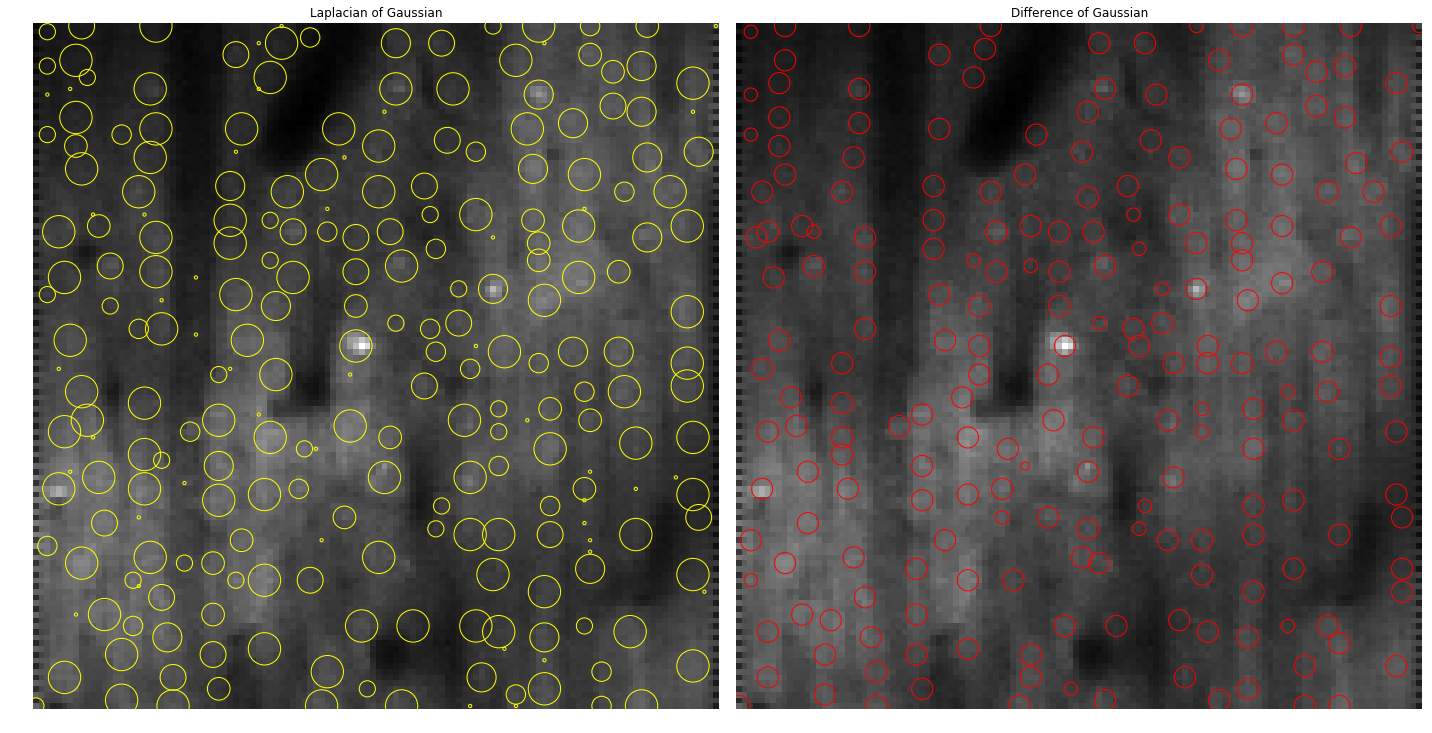

slice12
(120, 120)
Slice12_ROIs_average_slices.png


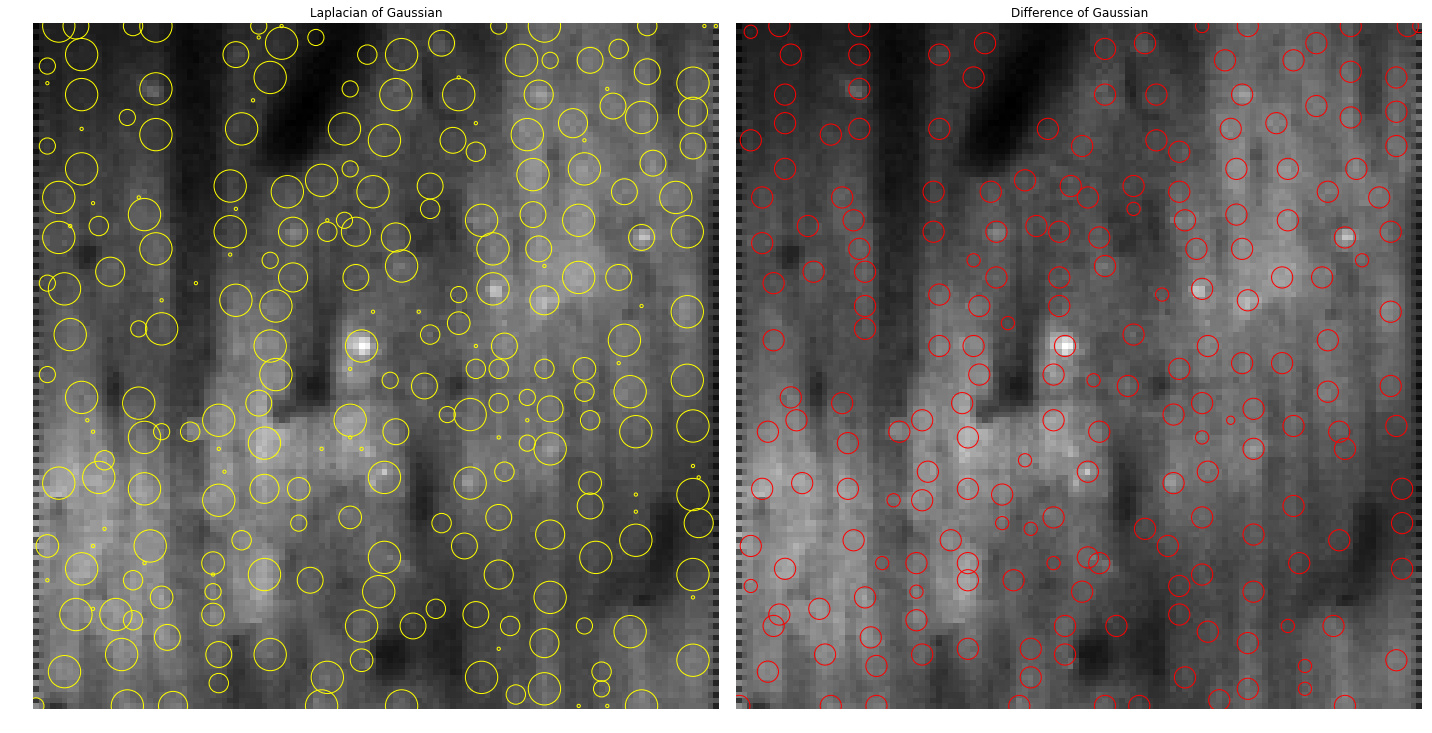

In [14]:

rois = dict()
nslices = 12 #30

max_sigma_val = 2
min_sigma_val = 0.2

for currslice in range(nslices):

    currslice_name = 'slice%i' % int(currslice+1)
    print currslice_name
    rois[currslice_name] = dict()

    # Read the image
    image = cv2.imread(os.path.join(source_dir, avg_vol_dir, avg_slices[currslice]), -1)
    print image.shape

    # Gaussian blur
    image_gaussian = filters.gaussian(image, sigma=1)

    # CLAHE
    image_processed = equalize_adapthist(image_gaussian, kernel_size=10)

    # Laplacian of Gaussians
    # blobs_log = blob_log(image_processed, max_sigma=6, min_sigma=3, threshold=.01)
    blobs_log = blob_log(image_processed, max_sigma=max_sigma_val, min_sigma=min_sigma_val, threshold=.005)

    blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2) # Compute radii in the 3rd column.

    # Difference of Gaussians
    blobs_dog = blob_dog(image_processed, max_sigma=max_sigma_val, min_sigma=min_sigma_val, threshold=.005)
    blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)

    # Save in array
    rois['slice%i' % (currslice+1)]['LoG'] = blobs_log
    rois['slice%i' % (currslice+1)]['DoG'] = blobs_dog


    # Plot that shit

    blobs_list = [blobs_log, blobs_dog]
    colors = ['yellow', 'red']
    titles = ['Laplacian of Gaussian', 'Difference of Gaussian']
    sequence = zip(blobs_list, colors, titles)

    fig, axes = plt.subplots(1, 2, figsize=(20, 10), sharex=True, sharey=True,
                             subplot_kw={'adjustable': 'box-forced'})
    ax = axes.ravel()

    for idx, (blobs, color, title) in enumerate(sequence):
        ax[idx].set_title(title)
        ax[idx].imshow(image, interpolation='nearest', cmap='gray')
        for blob in blobs:
            y, x, r = blob
            c = plt.Circle((x, y), r, color=color, linewidth=1, fill=False)
            ax[idx].add_patch(c)
        ax[idx].set_axis_off()

    plt.tight_layout()

    imname = 'Slice%02d_ROIs_%s.png' % (currslice+1, avg_vol_dir)
    print imname

    roi_dir = 'ROIs_%s' % avg_vol_dir
    if not os.path.exists(os.path.join(source_dir, roi_dir, 'images')):
        os.mkdir(os.path.join(source_dir, roi_dir))

    plt.savefig(os.path.join(source_dir, roi_dir, imname))

    plt.show()
    

In [16]:
import scipy.io
roi_mat_fn = 'rois_%s.mat' % avg_vol_dir
scipy.io.savemat(os.path.join(source_dir, roi_dir, roi_mat_fn), mdict=rois)
print os.path.join(source_dir, roi_mat_fn)

/nas/volume1/2photon/RESDATA/TEFO/20161218_CE024/retinotopy5/DATA/rois_average_slices.mat


In [20]:
print rois.keys()[0]
print int(rois.keys()[0][5:])

slice4
4


In [21]:
all_centroids_log = [(rois[slicekey]['LoG'][:,1], rois[slicekey]['LoG'][:,0], int(slicekey[5:])) for slicekey in rois.keys()]

In [22]:
centroids = dict()
centroids['LoG'] = []
centroids['DoG'] = []

for slicekey in rois.keys():
    centroids1 = [[rois[slicekey]['LoG'][r,1], rois[slicekey]['LoG'][r,0], int(slicekey[5:])] for r in range(rois[slicekey]['LoG'].shape[0])]
    centroids2 = [[rois[slicekey]['DoG'][r,1], rois[slicekey]['DoG'][r,0], int(slicekey[5:])] for r in range(rois[slicekey]['DoG'].shape[0])]

    centroids['LoG'].append(centroids1)
    centroids['DoG'].append(centroids2)

In [23]:
import itertools
centroids['LoG'] = list(itertools.chain.from_iterable(centroids['LoG']))
centroids['DoG'] = list(itertools.chain.from_iterable(centroids['DoG']))

In [24]:
len(centroids['LoG'])

3025

In [25]:

centroids_mat_fn = 'centroids_%s.mat' % avg_vol_dir
scipy.io.savemat(os.path.join(source_dir, roi_dir, centroids_mat_fn), mdict=centroids)
print os.path.join(source_dir, centroids_mat_fn)

/nas/volume1/2photon/RESDATA/TEFO/20161218_CE024/retinotopy5/DATA/centroids_average_slices.mat
